+ Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

+ Importing Dataset & Merging

In [2]:
# Load zone lookup data
df_zones = pd.read_csv('taxi_zone_lookup.csv')
df_zones.columns = df_zones.columns.str.strip()
df_zones['LocationID'] = df_zones['LocationID'].astype(str)
df_zones['Borough'] = df_zones['Borough'].str.strip()
df_zones['Zone'] = df_zones['Zone'].str.strip()
df_zones['service_zone'] = df_zones['service_zone'].str.strip().str.lower()
df_zones['service_zone'] = df_zones['service_zone'].replace({'boro zone': 'borough zone'})

# Load trip data
df_trips = pd.read_parquet('yellow_tripdata_2025-01.parquet')
df_trips.columns = df_trips.columns.str.strip()
df_trips['PULocationID'] = df_trips['PULocationID'].astype(str)
df_trips['DOLocationID'] = df_trips['DOLocationID'].astype(str)

# Merge pickup location info and rename columns
df_merged = pd.merge(df_trips, df_zones, 
                    left_on='PULocationID', 
                    right_on='LocationID',
                    how='left')
df_merged = df_merged.rename(columns={
    'Borough': 'PUBorough',
    'Zone': 'PUZone',
    'service_zone': 'PUservice_zone'
})

# Merge dropoff location info and rename columns
df_merged = pd.merge(df_merged, df_zones, 
                    left_on='DOLocationID', 
                    right_on='LocationID',
                    how='left')
df_merged = df_merged.rename(columns={
    'Borough': 'DOBorough',
    'Zone': 'DOZone',
    'service_zone': 'DOservice_zone'
})

# Drop the extra LocationID columns
df_merged = df_merged.drop(columns=['LocationID_x', 'LocationID_y'])

# Initial data check
print("Initial merged data:")
print(df_merged.head())
print("\nData info:")
print(df_merged.info())
print("\nMissing values:")
print(df_merged.isnull().sum())

Initial merged data:
   VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         1  2025-01-01 00:18:38   2025-01-01 00:26:59              1.0   
1         1  2025-01-01 00:32:40   2025-01-01 00:35:13              1.0   
2         1  2025-01-01 00:44:04   2025-01-01 00:46:01              1.0   
3         2  2025-01-01 00:14:27   2025-01-01 00:20:01              3.0   
4         2  2025-01-01 00:21:34   2025-01-01 00:25:06              3.0   

   trip_distance  RatecodeID store_and_fwd_flag PULocationID DOLocationID  \
0           1.60         1.0                  N          229          237   
1           0.50         1.0                  N          236          237   
2           0.60         1.0                  N          141          141   
3           0.52         1.0                  N          244          244   
4           0.66         1.0                  N          244          116   

   payment_type  ...  total_amount  congestion_surcharge  Airport

+ Cleaning data

In [3]:
# 1. Replace 'Unknown' with NaN
df_merged.replace('Unknown', pd.NA, inplace=True)

# 2. Handle missing values
print("\nMissing values before cleaning:")
print(df_merged[['PUBorough', 'PUZone', 'DOBorough', 'DOZone']].isnull().sum())

# Fill missing values with mode
for col in ['PUBorough', 'PUZone', 'DOBorough', 'DOZone']:
    df_merged[col] = df_merged[col].fillna(df_merged[col].mode()[0])

# 3. Clean passenger_count
df_merged = df_merged.dropna(subset=['passenger_count'])
df_merged = df_merged[df_merged['passenger_count'] > 0]
df_merged = df_merged[df_merged['passenger_count'].between(1, 6)]
df_merged['passenger_count'] = df_merged['passenger_count'].astype(int)

# 4. Clean trip_distance
df_merged = df_merged[(df_merged['trip_distance'] > 0.05) & 
                     (df_merged['trip_distance'] < 50)]

# 5. Clean datetime columns
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'])
df_merged['tpep_dropoff_datetime'] = pd.to_datetime(df_merged['tpep_dropoff_datetime'])
df_merged = df_merged[df_merged['tpep_pickup_datetime'] < df_merged['tpep_dropoff_datetime']]

# 6. Clean payment data
payment_map = {
    1: 'Credit card',
    2: 'Cash',
    3: 'No charge',
    4: 'Dispute'
}
df_merged['payment_type_label'] = df_merged['payment_type'].map(payment_map)
df_merged['payment_type'] = df_merged['payment_type'].fillna(df_merged['payment_type'].mode()[0]).astype('category')

# 7. Clean fare amounts
df_merged = df_merged[df_merged['total_amount'] > 0]

# 8. Handle same pickup/dropoff locations
same_loc_trips = df_merged[df_merged['PULocationID'] == df_merged['DOLocationID']]
print(f"\nTrips with identical pickup/dropoff: {len(same_loc_trips)}")

# 9. logical passenger count filtering (6 people is already pushing it)
df_merged = df_merged[
    (df_merged['total_amount'] > 0) &
    (df_merged['total_amount'] < 300) &
    (df_merged['passenger_count'] > 0) &
    (df_merged['passenger_count'] < 6)
].copy()
df_merged['passenger_count'] = df_merged['passenger_count'].astype(str)

# Final check
print("\nCleaned data summary:")
print(f"Total rows: {len(df_merged)}")
print("Missing values after cleaning:")
print(df_merged[['PUBorough', 'DOBorough']].isnull().sum())
print("\nData successfully cleaned!")

# Cloumns check
print("\nColumns:")
df_merged.columns  # Display the columns of the cleaned data


Missing values before cleaning:
PUBorough     9521
PUZone        8141
DOBorough    24062
DOZone       11976
dtype: int64

Trips with identical pickup/dropoff: 126239

Cleaned data summary:
Total rows: 2797877
Missing values after cleaning:
PUBorough    0
DOBorough    0
dtype: int64

Data successfully cleaned!

Columns:


Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee',
       'cbd_congestion_fee', 'PUBorough', 'PUZone', 'PUservice_zone',
       'DOBorough', 'DOZone', 'DOservice_zone', 'payment_type_label'],
      dtype='object')

#                                    Number of Taxi Trips by Hour and Day

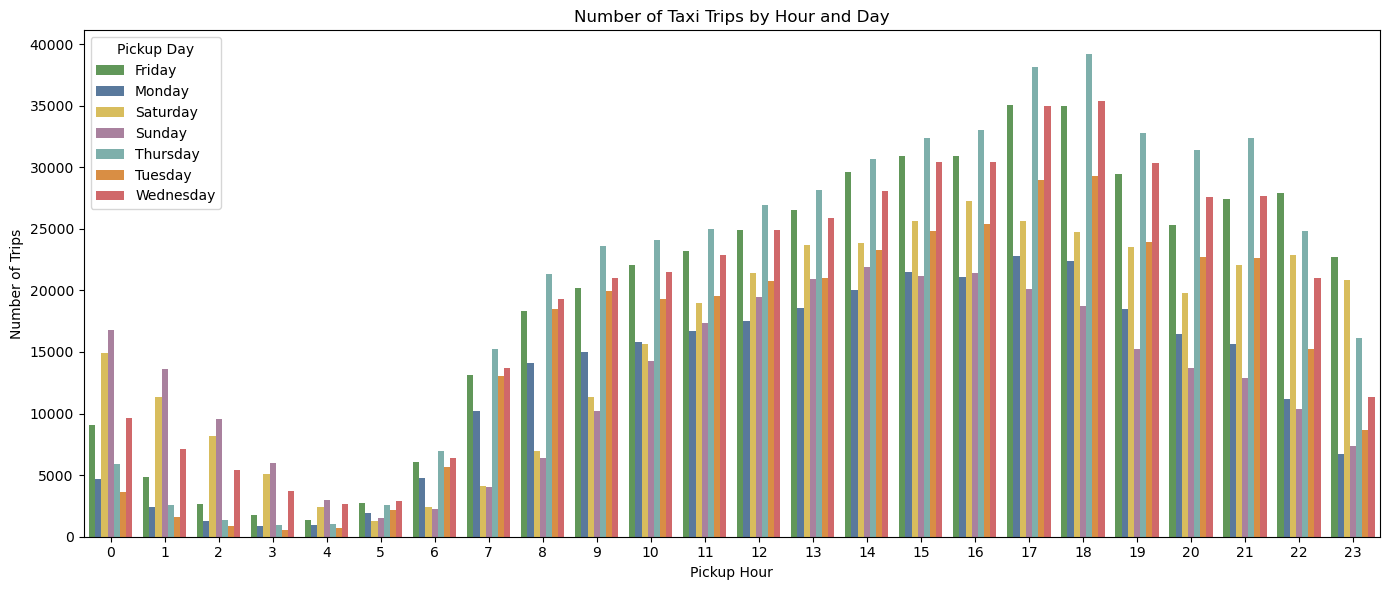

In [4]:
# Ensure datetime is parsed correctly
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'])

# Extract hour and day of week
df_merged['pickup_hour'] = df_merged['tpep_pickup_datetime'].dt.hour
df_merged['pickup_day'] = df_merged['tpep_pickup_datetime'].dt.day_name()

# Aggregate trips by hour and day
hour_day_counts = df_merged.groupby(['pickup_hour', 'pickup_day']).size().unstack()

# Define a custom color palette (one color per day of week)
day_palette = {
    'Monday': '#4e79a7',    # Soft blue
    'Tuesday': '#f28e2b',   # Soft orange
    'Wednesday': '#e15759', # Soft red
    'Thursday': '#76b7b2',  # Soft teal
    'Friday': '#59a14f',    # Soft green
    'Saturday': '#edc948',  # Soft yellow
    'Sunday': '#b07aa1'    # Soft purple
}

# Plot with custom colors
plt.figure(figsize=(14, 6))
sns.barplot(
    data=hour_day_counts.reset_index().melt(id_vars='pickup_hour', var_name='Day', value_name='Trips'),
    x='pickup_hour',
    y='Trips',
    hue='Day',
    palette=day_palette
)
plt.title('Number of Taxi Trips by Hour and Day')
plt.xlabel('Pickup Hour')
plt.ylabel('Number of Trips')
plt.legend(title='Pickup Day')
plt.tight_layout()
plt.show()

+ Observation:

    + The number of taxi trips peaks around 18:00 (6 PM) on all days of the week, with Friday and Saturday showing slightly higher peaks.
    
    + The lowest number of trips occurs between 3:00 AM and 5:00 AM across all days, though weekends (Saturday and Sunday) have higher late-night and early-morning trip counts compared to weekdays.

+ Interpretation:

    + The evening rush hour (around 6 PM) is the busiest time for taxi usage, likely due to commuters returning home from work, with increased demand on Fridays and Saturdays possibly tied to social and leisure activities.
    
    + Late-night and early-morning hours see the least demand, as most people are at home, though weekends show higher activity during these times, likely due to nightlife and extended social gatherings.

# Taxi Trip Patterns: Weekday vs. Weekend

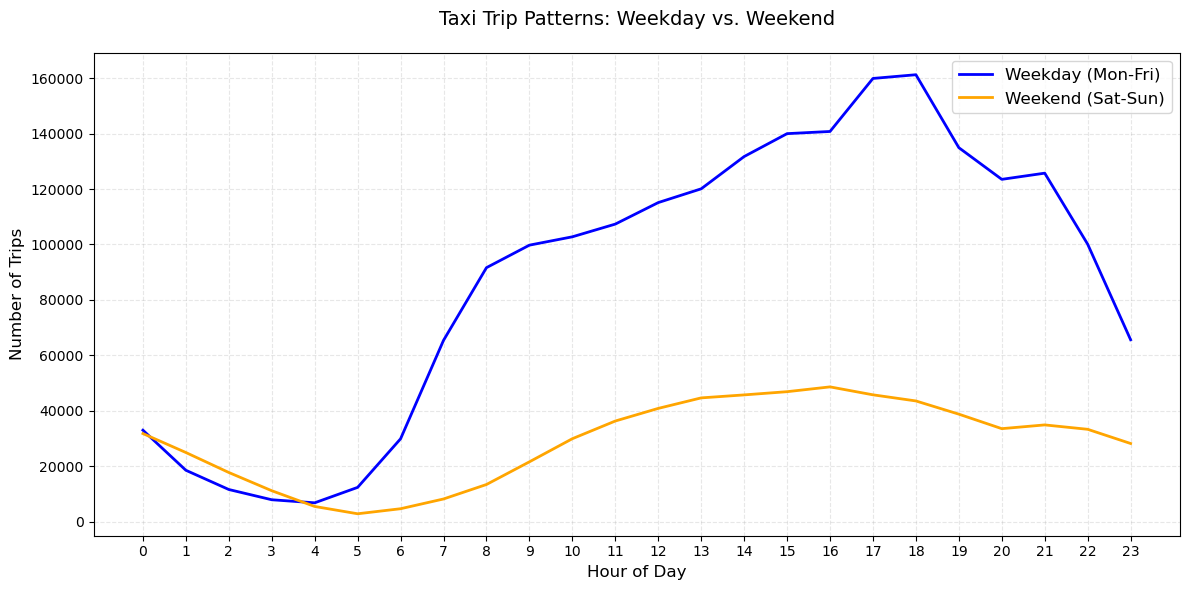

In [5]:
# Making the column actually in datetime format
df_merged['tpep_pickup_datetime'] = pd.to_datetime(df_merged['tpep_pickup_datetime'])

# Extract hour and weekday/weekend info
df_merged['pickup_hour'] = df_merged['tpep_pickup_datetime'].dt.hour
df_merged['pickup_day'] = df_merged['tpep_pickup_datetime'].dt.day_name()
df_merged['is_weekend'] = df_merged['pickup_day'].isin(['Saturday', 'Sunday'])

# Aggregate counts by hour and weekday/weekend
hourly_counts = df_merged.groupby(['is_weekend', 'pickup_hour']).size().unstack(level=0)
hourly_counts.columns = ['Weekday', 'Weekend']

# Plot
plt.figure(figsize=(12, 6))
plt.plot(hourly_counts.index, hourly_counts['Weekday'], 
         label='Weekday (Mon-Fri)', color='blue', linewidth=2)
plt.plot(hourly_counts.index, hourly_counts['Weekend'], 
         label='Weekend (Sat-Sun)', color='orange', linewidth=2)

# Formatting
plt.title('Taxi Trip Patterns: Weekday vs. Weekend', fontsize=14, pad=20)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Number of Trips', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(alpha=0.3, linestyle='--')
plt.legend(fontsize=12)
plt.tight_layout()

plt.show()

+ Observations:
    + Dominance of Weekday Demand:

      Weekdays (Mon–Fri) show significantly higher taxi usage overall, with demand beginning to rise sharply at 8 AM (likely work commutes) and peaking around 18:00 (6 PM) (evening rush hour).
    
    Weekends (Sat–Sun) exhibit consistently lower demand, with no pronounced morning spike, suggesting fewer structured travel routines.
    
    + Convergence at 4 AM:
 
      
        Both weekday and weekend demand nearly collide around 4 AM, marking the lowest point of taxi usage. This aligns with the previous graph’s finding that 4–5 AM is the quietest time for taxis citywide.
    
    + Weekend Behavior:
 
      
        Weekends show a delayed morning rise (no 8 AM spike), likely due to people sleeping in.
    
        A secondary evening peak (around 18:00–20:00) suggests social/leisure trips replace work commutes.

+ Interpretation:

  
    + Work-Driven Weekdays:
 
      
        The weekday spikes reflect predictable commuting patterns (home → work → home), with taxis serving as a bridge between transit hubs or for time-sensitive trips. The dominance of weekday demand underscores taxis’ role in supporting economic activity.
    
    + Weekend Rest vs. Nightlife:
 
      
        Lower weekend demand aligns with reduced formal schedules, as people prioritize rest or local activities. However, the persistent evening peak hints at taxis being used for dining, events, or nightlife—just starting later than work commutes.
    
    + 4 AM Lull:
 
      
        The convergence at 4 AM highlights a citywide "non-active window" where neither work nor leisure drives demand. This could inform taxi fleet management (e.g., fewer active drivers during these hours).

# Distribution of total trip amounts

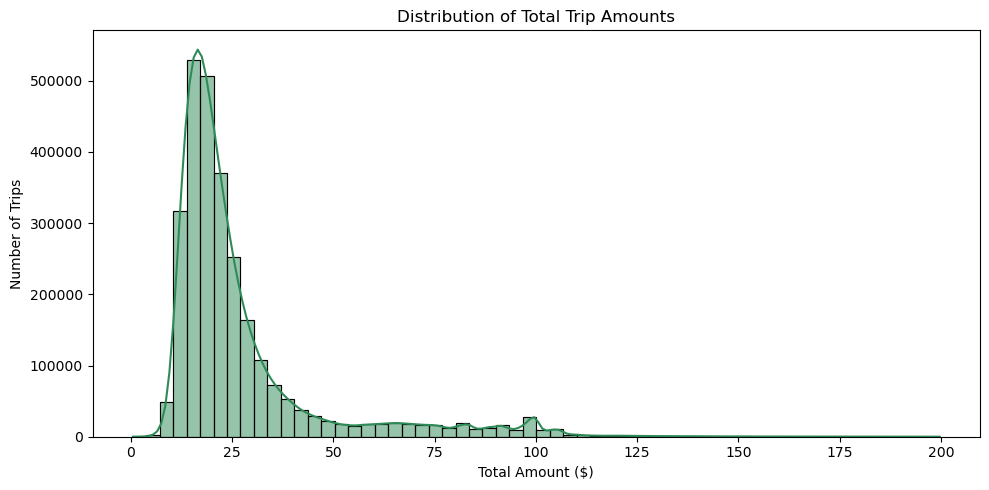

In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df_merged[df_merged['total_amount'] < 200]['total_amount'], bins=60, kde=True, color='seagreen')
plt.title("Distribution of Total Trip Amounts")
plt.xlabel("Total Amount ($)")
plt.ylabel("Number of Trips")
plt.tight_layout()
plt.show()

# Daily Taxi Trips and Total Amount Collected Over Time

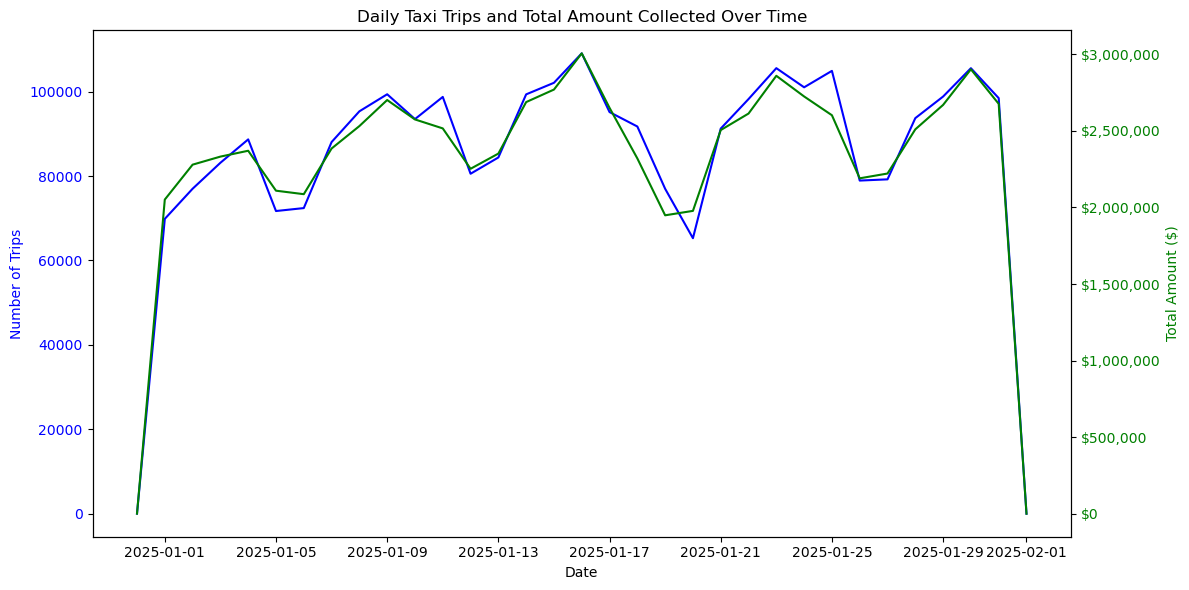

In [7]:
# Create daily summary
daily_summary = df_merged.resample('D', on='tpep_pickup_datetime').agg(
    {'VendorID': 'count', 'total_amount': 'sum'}
).rename(columns={
    'VendorID': 'nb of trips',
    'total_amount': 'total amount that day'
})
# We'll reuse the cleaned `daily_summary` from before

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot number of trips on left y-axis
ax1.plot(daily_summary.index, daily_summary['nb of trips'], color='blue', label='Number of Trips')
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Trips', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot total amount on right y-axis
ax2 = ax1.twinx()
ax2.plot(daily_summary.index, daily_summary['total amount that day'], color='green', label='Total Amount ($)')
ax2.set_ylabel('Total Amount ($)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Title and layout
plt.title('Daily Taxi Trips and Total Amount Collected Over Time')
fig.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()

+ Observation & Interpretation
    + The daily trends in number of trips and total amount collected exhibit strong correlation, suggesting that higher trip volumes generally correspond to increased revenue. However, an anomaly is observed on January 21st, where the total amount collected significantly deviates from the expected trend relative to trip volume.

+ Interpretation of Anomaly (Jan 21st)
    + The divergence between trip count and revenue on this date indicates:

        + Higher Average Fare per Trip: The total amount increased disproportionately compared to the number of trips, implying either:

            + Longer trip distances (e.g., due to a major event, such as a concert, sports game, or convention).

            + Surge pricing (e.g., during peak demand or inclement weather).

            + Airport trips (long-haul rides to/from airports, which typically cost more).




# Density Heatmap of the relation between the total amount paid and the trip distance 

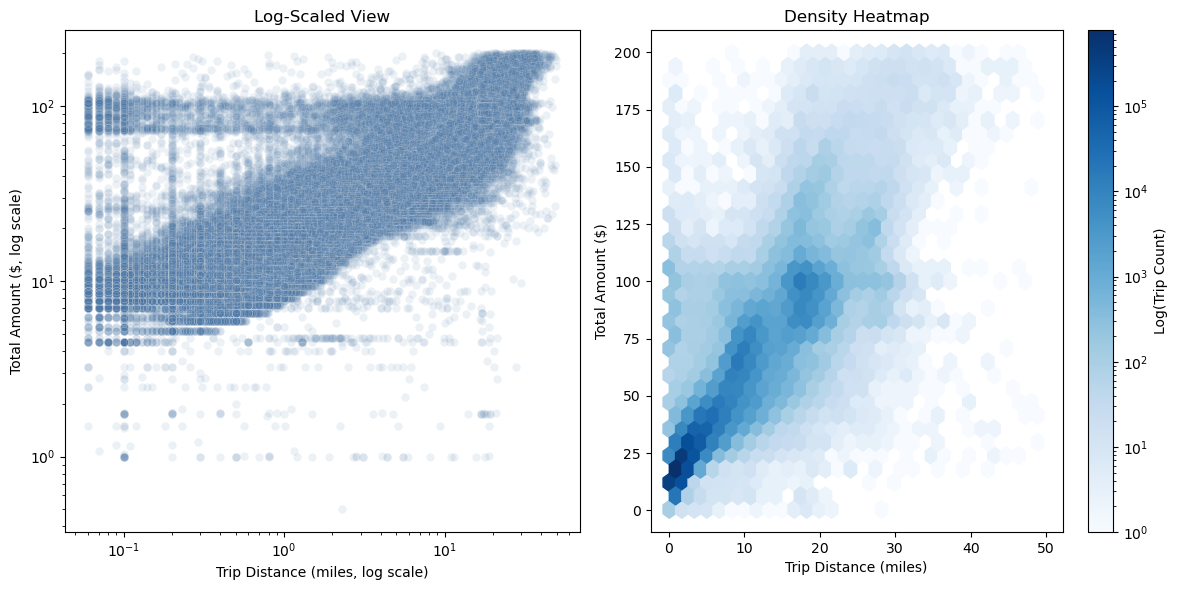

In [8]:
# Filter realistic trip distances (adjust thresholds as needed)
df_clean = df_merged[
    (df_merged['trip_distance'] > 0) & 
    (df_merged['trip_distance'] < 50) & 
    (df_merged['total_amount'] > 0) & 
    (df_merged['total_amount'] < 200)
]

# Create figure with adjusted scales
plt.figure(figsize=(12, 6))

# Scatter plot with log scaling
plt.subplot(121)
sns.scatterplot(
    data=df_clean,
    x='trip_distance',
    y='total_amount',
    alpha=0.1,
    color='#4e79a7'
)
plt.xscale('log')  # Logarithmic x-axis
plt.yscale('log')  # Logarithmic y-axis
plt.xlabel('Trip Distance (miles, log scale)')
plt.ylabel('Total Amount ($, log scale)')
plt.title('Log-Scaled View')

# Hexbin with linear scaling
plt.subplot(122)
plt.hexbin(
    x=df_clean['trip_distance'],
    y=df_clean['total_amount'],
    gridsize=30,
    cmap='Blues',
    mincnt=1,
    bins='log'  
)
plt.colorbar(label='Log(Trip Count)')
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Total Amount ($)')
plt.title('Density Heatmap')

plt.tight_layout()
plt.show()

+ Observation
    + The log-scaled density heatmap reveals a strong linear relationship between log(trip distance) and log(total amount), indicating a consistent power-law-like trend in the data. The highest density of trips follows a clear diagonal pattern, suggesting that fare increases proportionally with distance, but with some deviations at extreme values (very short or very long trips). The log scaling helps visualize the distribution more clearly, showing that most trips cluster in a mid-range of distances and fares, while fewer trips occur at the lower and higher extremes.

+ Interpretation
    + The near-linear trend in the log-log plot implies that the fare structure is multiplicatively scaled with distance rather than purely additive. This aligns with typical taxi pricing models, where:

        + Base fare + distance-based charges dominate, creating a log-linear relationship.

        + Short trips may show slightly higher variability (e.g., minimum fares, idle time charges).

        + Long trips could deviate due to flat-rate agreements, highway tolls, or surge pricing.

    + The heatmap’s concentration in the mid-range suggests that most trips follow standard metered pricing, while outliers (sparser regions) may reflect non-standard fares, discounts, or premium services. The log scaling also highlights that trip frequency decreases exponentially with distance, meaning most customers take moderate-length rides rather than extremely short or long ones.

# Total Amount by Payment Type (Filtered)

C:\Users\AIGLE\AppData\Local\Temp\ipykernel_12760\989477388.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


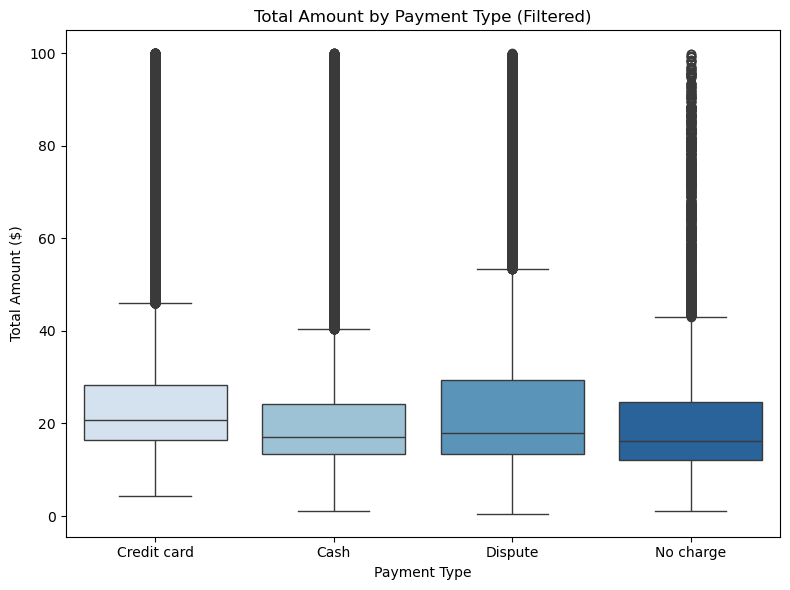

In [9]:
# Filter data to remove extreme outliers
df_clean = df_merged[(df_merged['total_amount'] > 0) & (df_merged['total_amount'] < 100)]


plt.figure(figsize=(8, 6))
sns.boxplot(
    x=df_clean['payment_type_label'],
    y=df_clean['total_amount'],
    palette='Blues'
)

plt.xlabel('Payment Type')
plt.ylabel('Total Amount ($)')
plt.title('Total Amount by Payment Type (Filtered)')
plt.tight_layout()
plt.show()


# Distribution of Trip Distance by Passenger Count

C:\Users\AIGLE\AppData\Local\Temp\ipykernel_12760\1029253265.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
C:\Users\AIGLE\AppData\Local\Temp\ipykernel_12760\1029253265.py:9: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


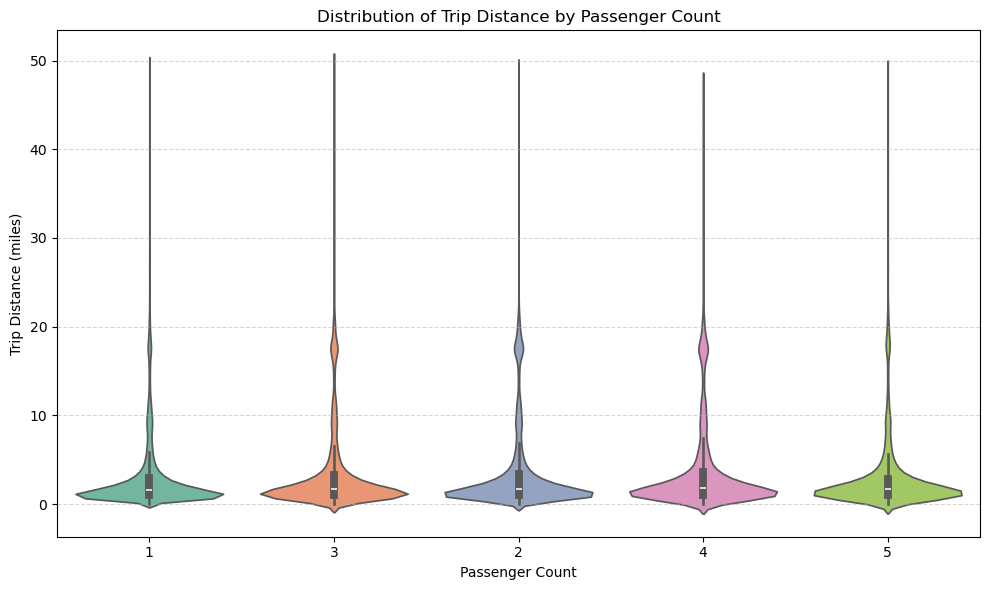

In [10]:
# Filter out zero or extreme trip distances
df_violin = df_merged[(df_merged['trip_distance'] > 0) & (df_merged['trip_distance'] < 50)]

# Convert passenger count to string for cleaner axis labeling
df_violin['passenger_count'] = df_violin['passenger_count'].astype(str)

# Plot
plt.figure(figsize=(10, 6))
sns.violinplot(
    x='passenger_count',
    y='trip_distance',
    data=df_violin,
    palette='Set2',
    inner='box',
    scale='width'
)

plt.title('Distribution of Trip Distance by Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Trip Distance (miles)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Total Amount vs Passenger Count

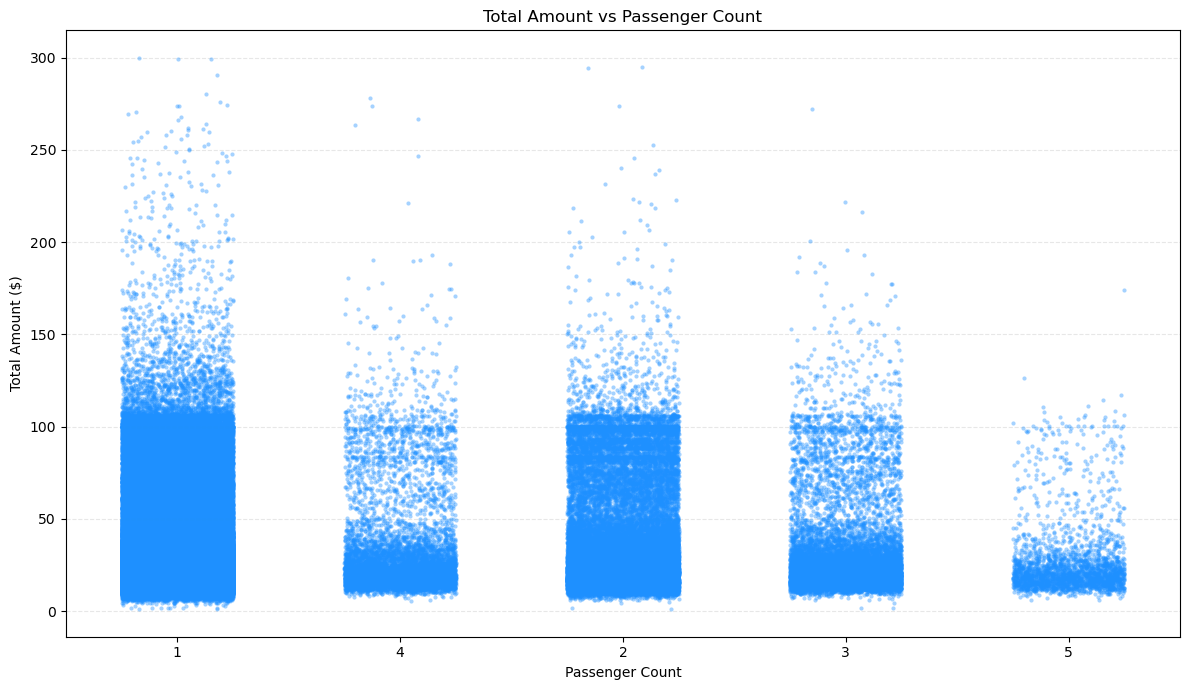

In [11]:
plt.figure(figsize=(12, 7))

# Jittered strip plot only
sns.stripplot(
    x='passenger_count',
    y='total_amount',
    data=df_merged.sample(frac=0.15, random_state=42),
    color='dodgerblue',
    alpha=0.4,
    jitter=0.25,
    size=3
)

plt.title("Total Amount vs Passenger Count")
plt.xlabel('Passenger Count')
plt.ylabel('Total Amount ($)')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# Taxi Trip Distribution by Zone

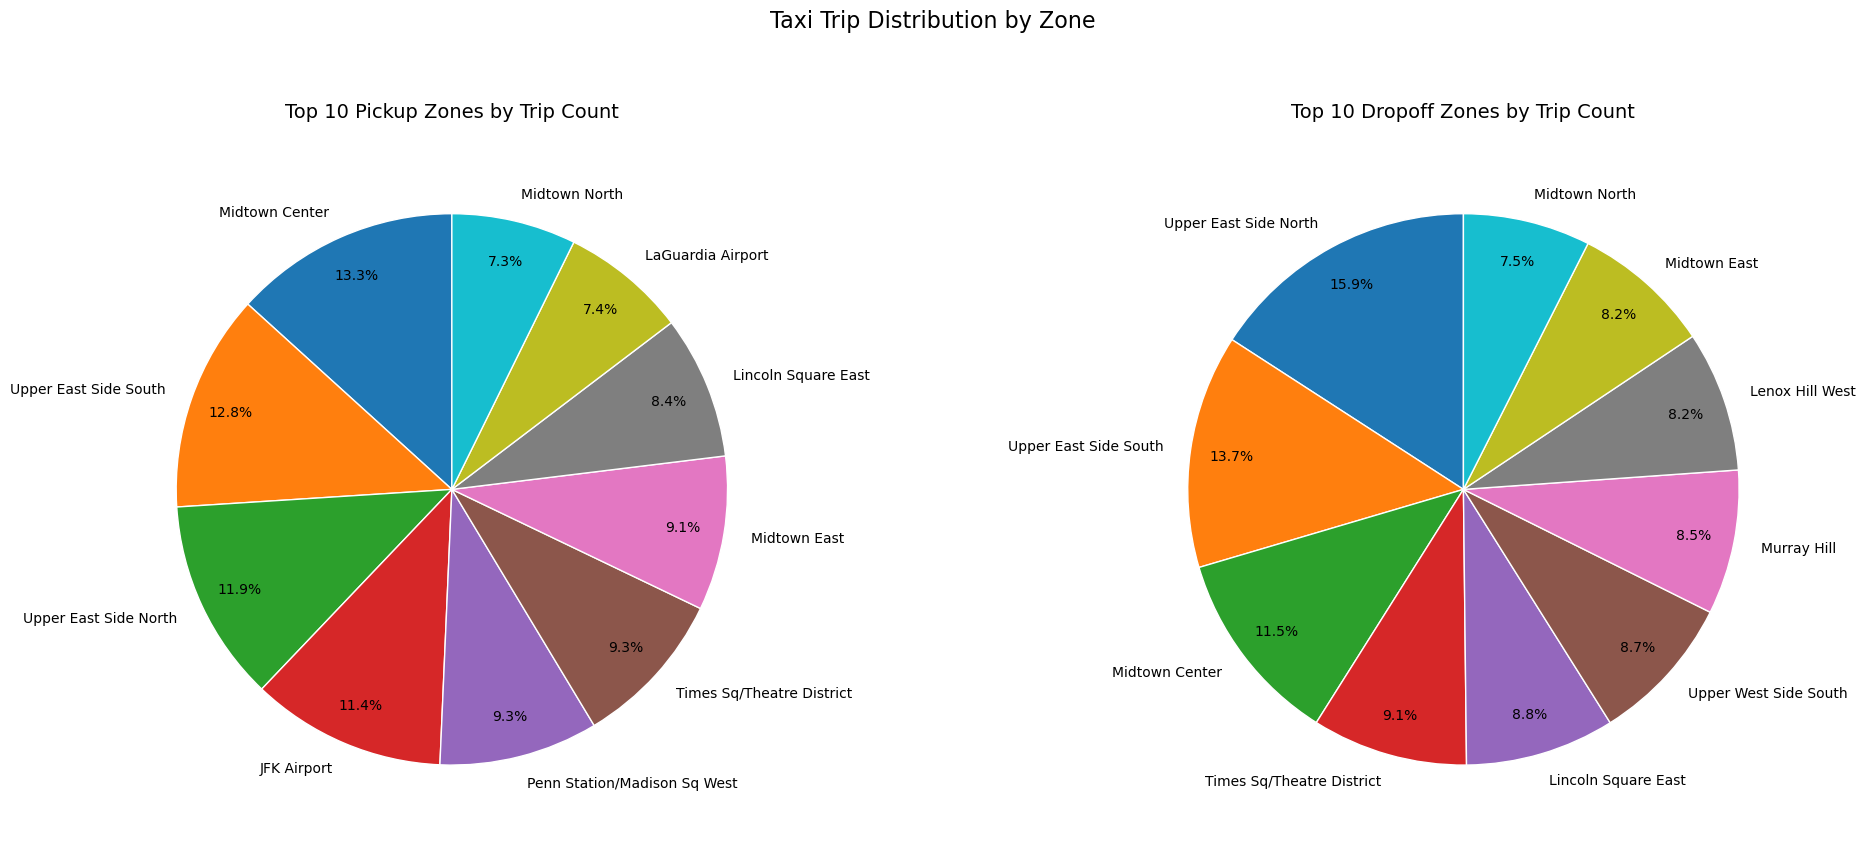

In [12]:
top_pickups = df_merged['PUZone'].value_counts().head(10)
top_dropoffs = df_merged['DOZone'].value_counts().head(10)

# Set up the figure
plt.figure(figsize=(20, 8))

# Pickup Zones Pie Chart (Left)
plt.subplot(1, 2, 1)
plt.pie(
    top_pickups,
    labels=top_pickups.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 10}
)
plt.title('Top 10 Pickup Zones by Trip Count', fontsize=14, pad=20)

# Dropoff Zones Pie Chart (Right)
plt.subplot(1, 2, 2)
plt.pie(
    top_dropoffs,
    labels=top_dropoffs.index,
    autopct='%1.1f%%',
    startangle=90,
    pctdistance=0.85,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 10}
)
plt.title('Top 10 Dropoff Zones by Trip Count', fontsize=14, pad=20)

# tital for the whole plot
plt.suptitle('Taxi Trip Distribution by Zone', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

+ Observation
    + The data shows:
        + Most popular pickup spot: Midtown Center (business/tourist hub)
        + Most popular dropoff spot: Upper East Side North (residential area)
          
+ Interpretation
    + This pattern suggests:
        + Work commutes: People take taxis from Midtown (offices) to Upper East Side (homes)
        + Daily routines: Students/workers traveling between these areas
        + Tourist activity: Visitors using taxis from central Midtown to residential zones
        + The simplest explanation is regular movement between work/school areas and residential neighborhoods.
      

# Need to know more dropoff locations?

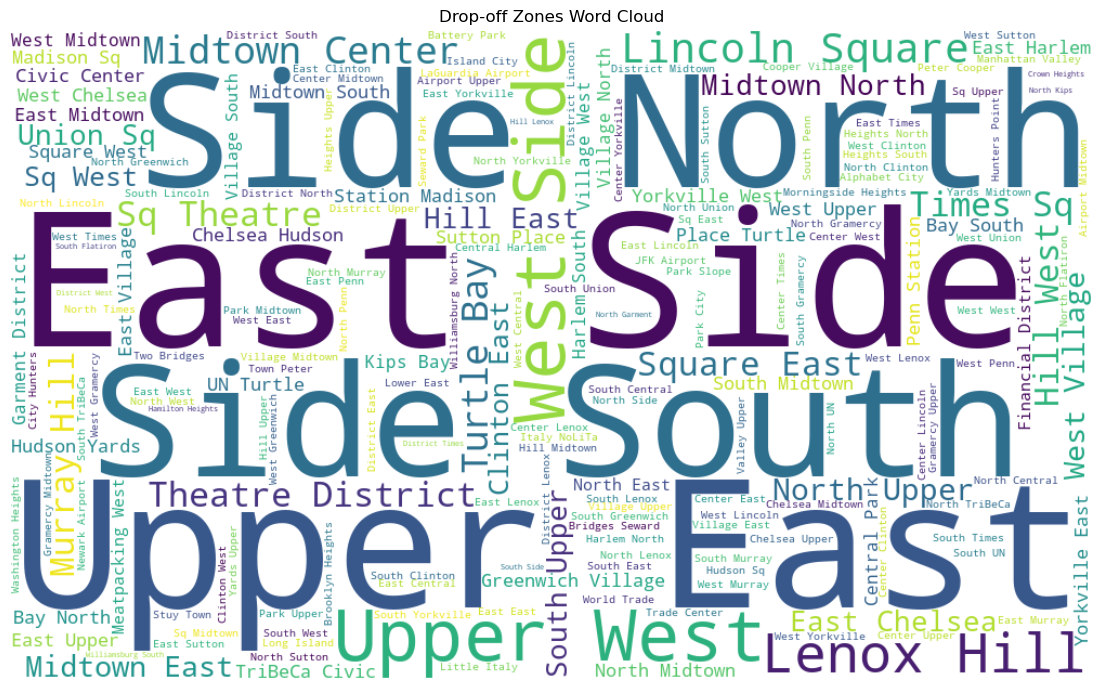

In [13]:
# Drop NaNs in the relevant column
text = ' '.join(df_merged['DOZone'].dropna().astype(str).tolist())

# Generate word cloud
wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color='white',
    colormap='viridis'
).generate(text)

# Display
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Drop-off Zones Word Cloud")
plt.tight_layout()
plt.show()

# Correlation Heatmap of Encoded Categorical Features

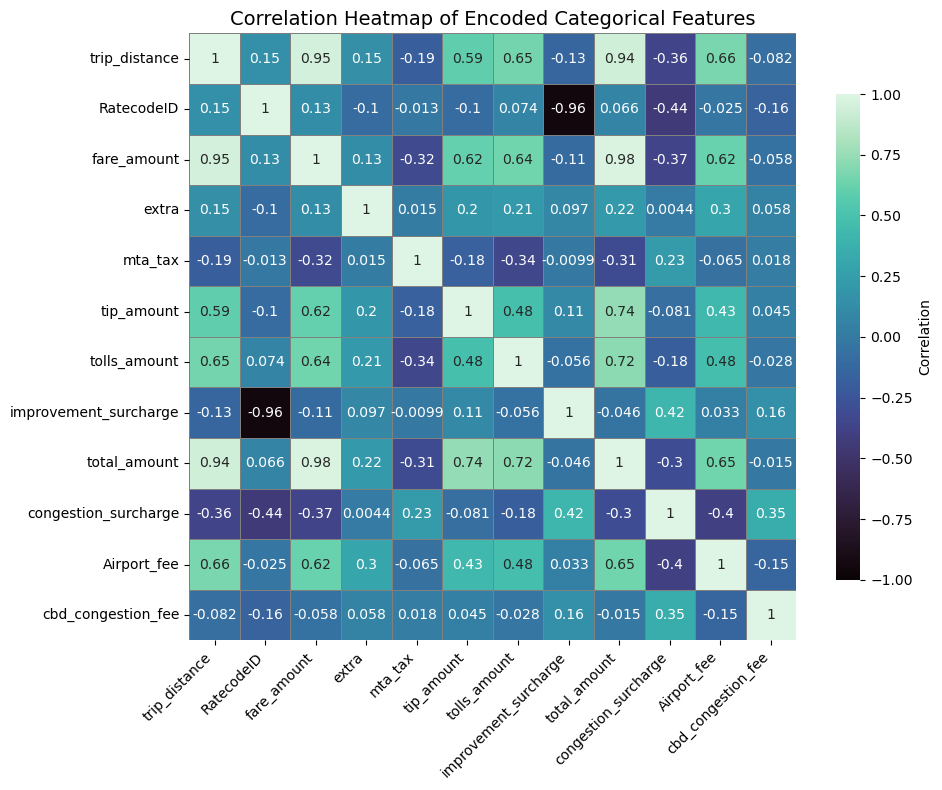

In [14]:
corr_matrix = df_merged.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='mako',        
    vmin=-1,
    vmax=1,
    annot_kws={"size": 10},
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8, "label": "Correlation"}
)

plt.title("Correlation Heatmap of Encoded Categorical Features", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
